# Solution Report

This file aims to study each approach, detailing it's main strategy as well as weighting in on it's advantages and disadvantages

**Important Note:** If you want to run this report, be sure you are using a **Linux** distribution

### Index
 - Setting up the Environment
 - Brute-Force
 - Open-MP
 - MPI
 - Comparison

## Setting up the Environment

To generate the example graphs, as well as checking if the cliques we found are correct, the `networkx` library is used. Let's make sure that this library is installed

In [8]:
%pip install networkx

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


Note that there aren't any graphs in the directory currently. Let's generate them using the `generate_graph.py` in the `scripts` folder. We will generate just one graph for now to be used as a test for the algorithms.

In [1]:
# generate_graph.py args: argv[1] = n_edges, argv[2] = probability of connection, argv[3] = filename
%run scripts/generate_graph.py 500 0.3 test_graph.txt

Graph generated and saved at /home/gabrielhso/Desktop/insper/2023.2/superComp/maximum-clique-detection/graphs'.


## Brute-Force

### Description
The brute force approach to finding the maximum clique in a graph is a method that systematically explores all possible combinations of vertices to identify the largest complete subgraph, known as a clique. It starts with an initial vertex and iteratively adds vertices to a candidate clique, checking if the addition maintains the clique property. This exhaustive approach guarantees the optimality of the solution, but its computational complexity grows exponentially with the number of vertices, making it impractical for large graphs.

### Running the Code

As we will evaluate the efficiency of the algorithim itself, we won't compile it with the optimization options of the compiler (-O flag). Also, we will use the -g to include debug symbols.


In [2]:
# Compiling
!g++ -Wall -O3 -g scripts/brute_force.cpp -o ./executables/brute_force

In [3]:
# Running
!./executables/brute_force graphs/test_graph.txt

Size of the maximum clique: 9
Maximum clique found:
[3, 36, 61, 259, 345, 361, 423, 433, 454]
Tempo de execução: 78 ms


Let's check the answer using the `check_answer.py` file

In [4]:
%run scripts/check_answer.py graphs/test_graph.txt

Size of the maximum clique:  9
Maximum cliques found:
[3, 36, 61, 259, 345, 361, 423, 433, 454]


The answer checks out! Now let's have a look at the performance of the code

In [6]:
!valgrind --tool=callgrind --callgrind-out-file=brute_force.out ./executables/brute_force graphs/test_graph.txt

==36303== Callgrind, a call-graph generating cache profiler
==36303== Copyright (C) 2002-2017, and GNU GPL'd, by Josef Weidendorfer et al.
==36303== Using Valgrind-3.18.1 and LibVEX; rerun with -h for copyright info
==36303== Command: ./executables/brute_force graphs/test_graph.txt
==36303== 
==36303== For interactive control, run 'callgrind_control -h'.
Size of the maximum clique: 9
Maximum clique found:
[3, 36, 61, 259, 345, 361, 423, 433, 454]
Tempo de execução: 2173 ms
==36303== 
==36303== Events    : Ir
==36303== Collected : 764021343
==36303== 
==36303== I   refs:      764,021,343


In [7]:
!callgrind_annotate brute_force.out scripts/brute_force.cpp --auto=no

--------------------------------------------------------------------------------
Profile data file 'brute_force.out' (creator: callgrind-3.18.1)
--------------------------------------------------------------------------------
I1 cache: 
D1 cache: 
LL cache: 
Timerange: Basic block 0 - 108346449
Trigger: Program termination
Profiled target:  ./executables/brute_force graphs/test_graph.txt (PID 36303, part 1)
Events recorded:  Ir
Events shown:     Ir
Event sort order: Ir
Thresholds:       99
Include dirs:     
User annotated:   scripts/brute_force.cpp
Auto-annotation:  off

--------------------------------------------------------------------------------
Ir                   
--------------------------------------------------------------------------------
764,021,343 (100.0%)  PROGRAM TOTALS

--------------------------------------------------------------------------------
Ir                    file:function
--------------------------------------------------------------------------------
5

Ao expandir a saída do `annotate`, é possível enxergar que as partes do código com maior proporção de execuções destinadas são:

Scripts e biblioteca
 - 76.21%: `brute_force.cpp` (o próprio código em c)
 - 12.04%: `stl_vector.h:main` (biblioteca vector)
 - 11.75%: outras bibliotecas

Não temos uma maneira de melhorar o código da biblioteca, então teremos que nos ater à mudança no nosso código.

Dentre as partes do programa, nota-se que: 
 - 4.83% das execuções são na função de ler o grafo `ReadGraph`
 - 75,83% das execuções ocorrem na seguinte parte:

```c++
( 0.03%)           for (int connection1 : connections)
                   {
                       vector<int> clique = {currentNode, connection1}; // Move initialization here
( 7.43%)               for (int connection2 : connections)
                       {
( 1.48%)                   bool inClique = true;
(24.16%)                   for (int member : clique)
                           {
(15.61%)                       if (graph[member][connection2] == 0)
(24.16%)                       inClique = false;
                           }
( 2.97%)                    if (inClique)
                                clique.push_back(connection2);
                        }
( 0.02%)                if (clique.size() > maximumClique.size())
                        maximumClique = clique;
                   }
               }
```

It seems that the issue is in the inner loops. Let's try to parallelize the code to make it faster.

## Open-MP

### Description

### Running the code

In [9]:
# Compiling
!g++ -Wall -O3 -fopenmp scripts/open_mp.cpp -o ./executables/open_mp

In [10]:
# Running
!./executables/open_mp graphs/test_graph.txt

Size of the maximum clique: 9
Maximum clique found:
[3, 36, 61, 259, 345, 361, 423, 433, 454]
Tempo de execução: 22 ms


## MPI

### Description

### Running the Code

As seen in the description, we need to run the code on a cluster environment.

## Comparison

Making graphs of different sizes

In [14]:
#Making graphs of sizes 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000
sizes = [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]
graph_names = list()

for size in sizes:
    %run scripts/generate_graph.py {size} 0.5 graph_{size}
    graph_names.append(f"graph_{size}.txt")


Graph generated and saved at /home/gabrielhso/Desktop/insper/2023.2/superComp/maximum-clique-detection/graphs'.
Graph generated and saved at /home/gabrielhso/Desktop/insper/2023.2/superComp/maximum-clique-detection/graphs'.
Graph generated and saved at /home/gabrielhso/Desktop/insper/2023.2/superComp/maximum-clique-detection/graphs'.
Graph generated and saved at /home/gabrielhso/Desktop/insper/2023.2/superComp/maximum-clique-detection/graphs'.
Graph generated and saved at /home/gabrielhso/Desktop/insper/2023.2/superComp/maximum-clique-detection/graphs'.
Graph generated and saved at /home/gabrielhso/Desktop/insper/2023.2/superComp/maximum-clique-detection/graphs'.
Graph generated and saved at /home/gabrielhso/Desktop/insper/2023.2/superComp/maximum-clique-detection/graphs'.
Graph generated and saved at /home/gabrielhso/Desktop/insper/2023.2/superComp/maximum-clique-detection/graphs'.
Graph generated and saved at /home/gabrielhso/Desktop/insper/2023.2/superComp/maximum-clique-detection/g

Fetching data from `brute_force.cpp` and `open_mp.cpp` files

In [26]:
# We can fetch the time data by splitting the program output
output = !./executables/brute_force graphs/graph_100.txt
print(output[-1].split(" "))
print(output[-1].split(" ")[-2])

['Tempo', 'de', 'execução:', '2', 'ms']
2


In [47]:
brute_force_times = list()
open_mp_times = list()

for graph in graph_names:
    output_brute_force = !./executables/brute_force graphs/{graph}
    brute_force_times.append(int(output_brute_force[-1].split(" ")[-2]))
    output_open_mp = !./executables/open_mp graphs/{graph}
    open_mp_times.append(int(output_open_mp[-1].split(" ")[-2]))

In [48]:
job_ids = [i for i in range(654, 664)]
MPI_times = list()

for job_id in job_ids:
    with open(f"slurm-out/slurm-{job_id}.out", "r") as f:
        MPI_times.append(int(f.read().split(" ")[-2]))


In [49]:
print(brute_force_times)
print(open_mp_times)
print(MPI_times)

[2, 11, 35, 74, 150, 253, 396, 611, 890, 1356]
[1, 6, 16, 36, 70, 122, 193, 292, 426, 617]
[279, 309, 292, 292, 385, 510, 864, 928, 1179, 1614]


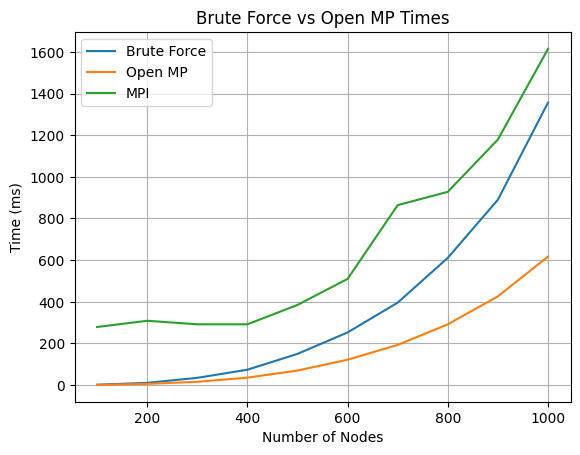

In [50]:
import matplotlib.pyplot as plt

# Plotting the graph
plt.plot(sizes, brute_force_times, label='Brute Force')
plt.plot(sizes, open_mp_times, label='Open MP')
plt.plot(sizes, MPI_times, label='MPI')
plt.xlabel('Number of Nodes')
plt.ylabel('Time (ms)')
plt.title('Brute Force vs Open MP Times')
plt.legend()
plt.grid()
plt.show()
